In [ ]:
!pip install ruptures
import ruptures as rpt

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
from scipy import signal
from scipy.signal import savgol_filter, medfilt

from scipy.signal import firwin, lfilter,find_peaks,filtfilt,hilbert,welch
from scipy.fftpack import fft, fftshift

from scipy import integrate

from scipy.integrate import cumtrapz
from scipy.stats import linregress

from tqdm import tqdm

 Fs=1000 hz
 Ts=0.001 s


Text(0.5, 1.0, 'Respuesta en frecuencia señal EMG')

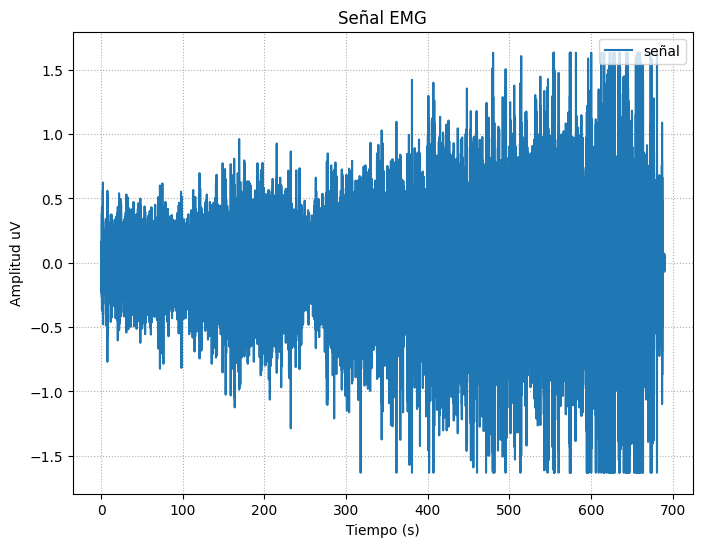

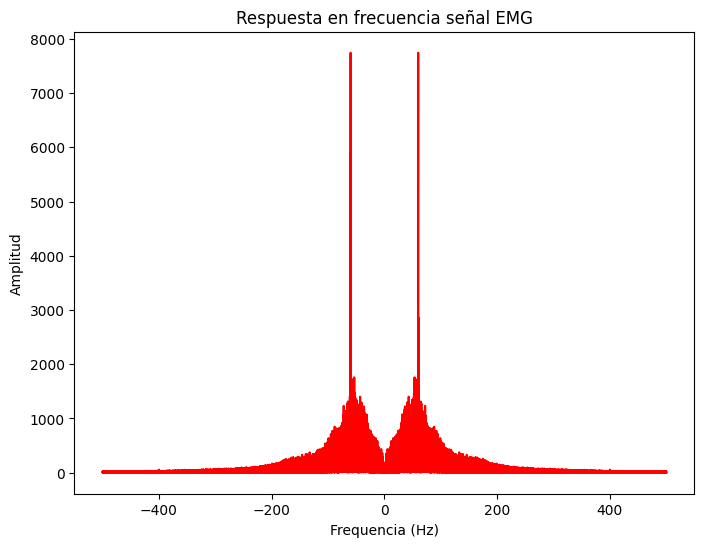

In [ ]:
f = open("gf.txt","r")
raw_data = f.read()  # con f.read() leemos todo el contenido
f.close()

raw_data
Fs = 1000
Ts = 1/Fs
print(f" Fs={Fs} hz\n Ts={Ts} s")

a = np.genfromtxt("./gf.txt", delimiter="\t",skip_header = 3)
eeg = a[:, 5]
N=len(eeg)
bits = 10 # Bits de la salida
volt_range = 3.3
eeg = (eeg/2**bits -1/2) * volt_range/1009
eeg=eeg*1000 # convertir los bits a mV
eeg = eeg - np.mean(eeg)
t = np.arange(1, len(eeg)+1)/Fs
plt.figure(figsize=(8, 6))
plt.plot(t, eeg, label="señal")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud uV")
plt.legend(loc="upper right")
plt.title("Señal EMG")
plt.grid(linestyle=":")


#FFT
def fft_fun(x, fs):
    X = fftshift(fft(x))
    N = len(X)
    w = 2 * np.pi * np.arange(N) / N
    w = np.unwrap(fftshift(w)) - 2 * np.pi
    wHz = w * fs / (2 * np.pi)
    return wHz, X


wHz, Y = fft_fun(eeg, Fs)

#Grafica FFT EEG
plt.figure(figsize=(8, 6))
plt.plot(wHz, np.abs(Y), "r")
plt.xlabel("Frequencia (Hz)")
plt.ylabel("Amplitud")
plt.title("Respuesta en frecuencia señal EMG")

0.113
0.127
1999


Text(0.5, 1.0, 'Respuesta en frecuencia señal EMG filtrada')

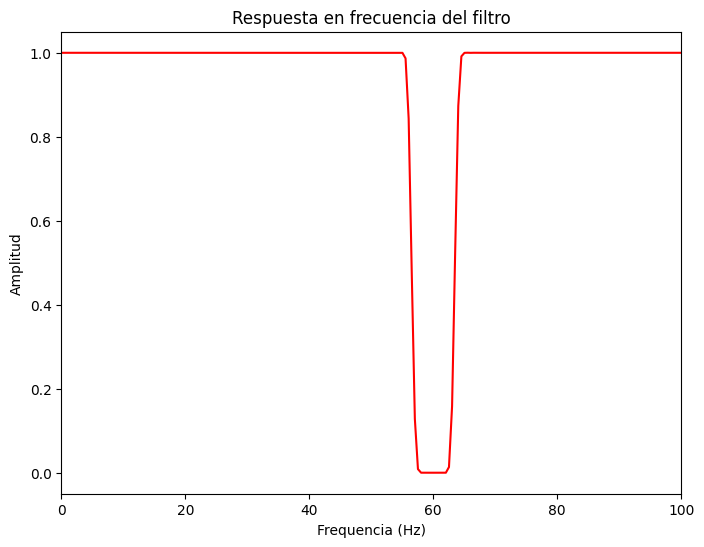

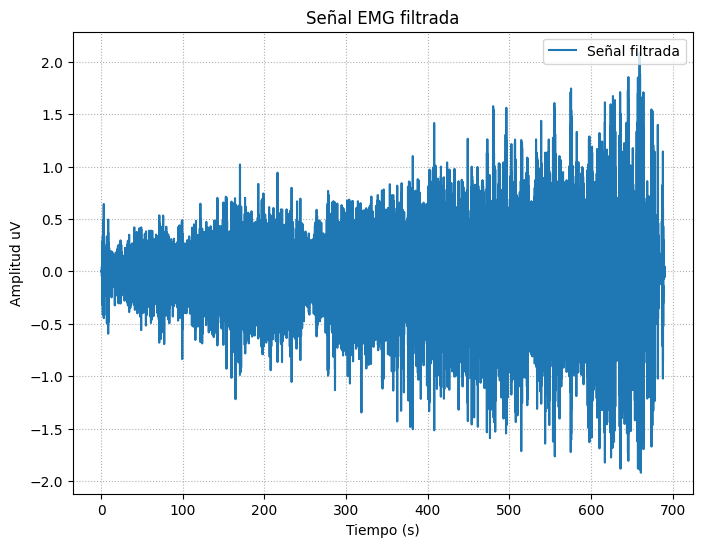

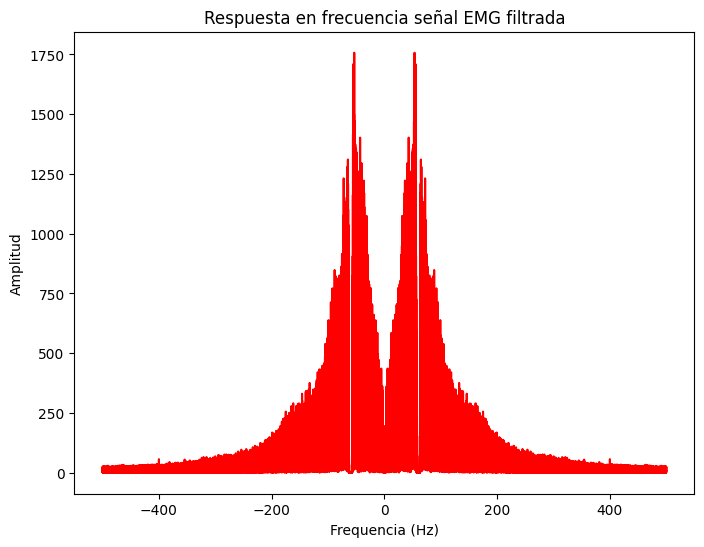

In [ ]:
# Creamos un filtro rechazabanda en 60 Hz
# Definir frecuencias de corte para filtro rechazabanda (RUIDO DE 60 HZ)
wp = 55  / (Fs / 2)
ws = 58  / (Fs / 2)
wc=(wp + ws) / 2
print(wc)
wp1 = 65  / (Fs / 2)
ws1 = 62  / (Fs / 2)
wc1=(wp1 + ws1) / 2

print(wc1)

dw= ws-wp
# Definir el orden del filtro
M =  int(np.floor(12 / dw))
print(M)

stopband_filter= firwin(numtaps=M, cutoff=[wc,wc1],  window='blackman')


wHz, Y = fft_fun(stopband_filter, Fs)

plt.figure(figsize=(8, 6))

plt.plot(wHz, np.abs(Y), "r")
plt.xlabel("Frequencia (Hz)")
plt.ylabel("Amplitud")
plt.title("Respuesta en frecuencia del filtro")
plt.xlim(0,100)



filtered_signal = lfilter(stopband_filter, 1, eeg)

wHz, filtered_signal_fft = fft_fun(filtered_signal, Fs)

t = np.arange(1, len(filtered_signal)+1)/Fs

plt.figure(figsize=(8, 6))
plt.plot(t, filtered_signal, label="Señal filtrada")
plt.title("Señal EMG filtrada")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud uV")
plt.legend(loc="upper right")
plt.grid(linestyle=":")



plt.figure(figsize=(8, 6))
plt.plot(wHz, np.abs(filtered_signal_fft), "r")
plt.xlabel("Frequencia (Hz)")
plt.ylabel("Amplitud")
plt.title("Respuesta en frecuencia señal EMG filtrada")




0.012
0.998


Text(0.5, 1.0, 'Respuesta en frecuencia señal EMG filtrada pasabanda final')

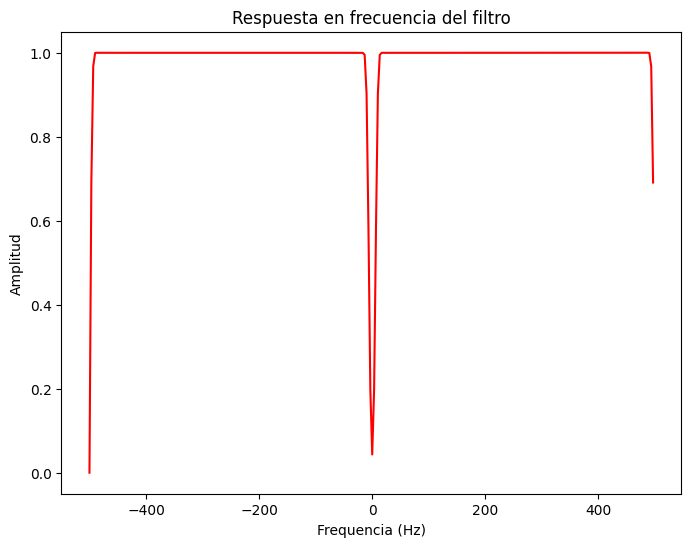

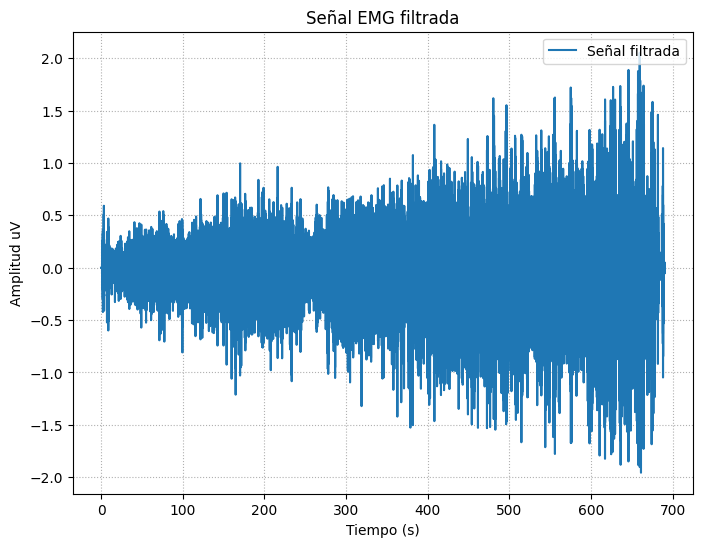

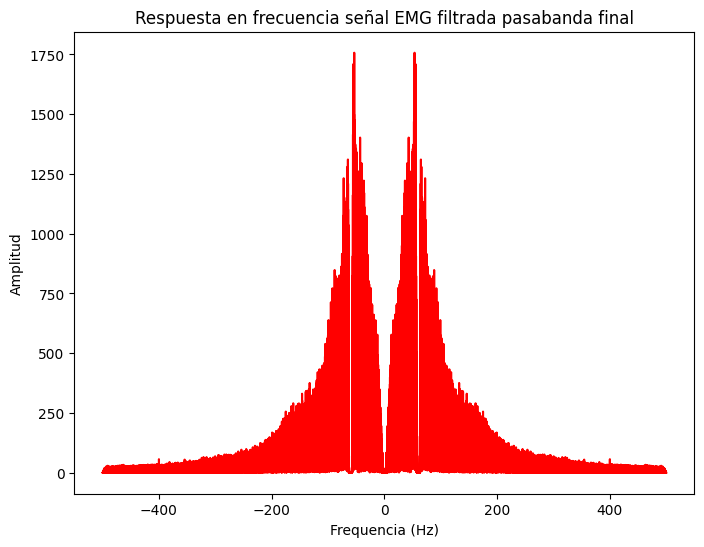

In [ ]:
# Se recomienda un filtro pasabanda con fc de 10 a 500 hz, se la aplicamos a la señal
#filtrada con el rechazabanda


wc_10= 6/ (Fs / 2)
print(wc_10)

wc_200=  499/ (Fs / 2)

print(wc_200)

# Definir el orden del filtro
M = 300

bandpass_filter= firwin(numtaps=M, cutoff=[wc_10,wc_200], pass_zero=False,  window='blackman')


wHz, Y = fft_fun(bandpass_filter, Fs)

plt.figure(figsize=(8, 6))

plt.plot(wHz, np.abs(Y), "r")
plt.xlabel("Frequencia (Hz)")
plt.ylabel("Amplitud")
plt.title("Respuesta en frecuencia del filtro")




filtered_signal2 = lfilter(bandpass_filter, 1, filtered_signal)

wHz, filtered_signal_fft2 = fft_fun(filtered_signal2, Fs)

t = np.arange(1, len(filtered_signal2)+1)/Fs

plt.figure(figsize=(8, 6))
plt.plot(t, filtered_signal2, label="Señal filtrada")
plt.title("Señal EMG filtrada")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud uV")
plt.legend(loc="upper right")
plt.grid(linestyle=":")



plt.figure(figsize=(8, 6))
plt.plot(wHz, np.abs(filtered_signal_fft2), "r")
plt.xlabel("Frequencia (Hz)")
plt.ylabel("Amplitud")
plt.title("Respuesta en frecuencia señal EMG filtrada pasabanda final")



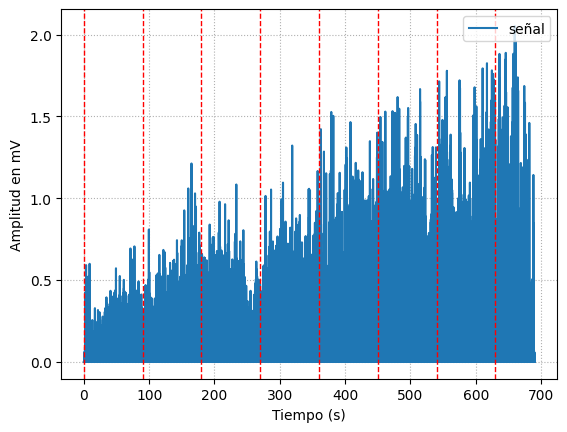

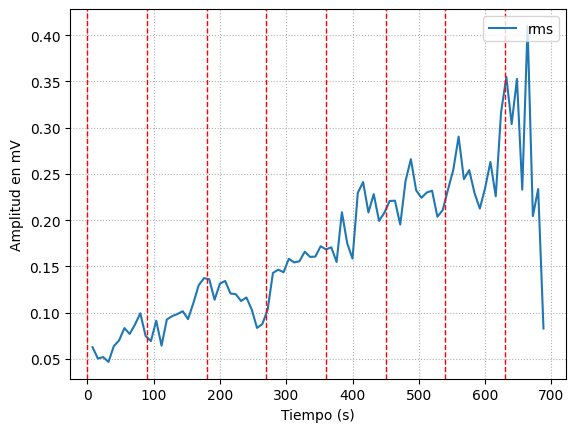

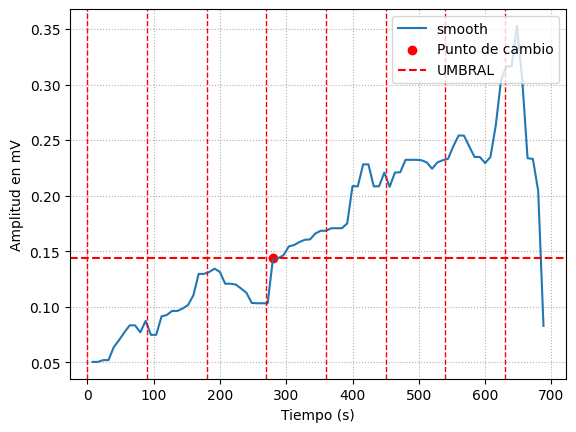

[35, 86]


'\nplt.figure()\nplt.plot(xarray, smoothed_emg_sg, label="smooth")\nplt.scatter(t[change_point2], smoothed_emg_median[change_point2], color=\'red\', label=\'Punto de cambio\')\n\nplt.grid(linestyle=":")\nplt.xlabel("Tiempo (s)")\nplt.ylabel("Amplitud en mV")\nplt.legend(loc="upper right")\nfor i in range(8):\n  plt.axvline(x=90*i, color=\'red\', linestyle=\'--\', linewidth=1)\nplt.show()\n'

In [ ]:
# EXTRACIÓN DE CARACTERÍSTICAS
xarray=t

muestras_por_grupo = 600
num_grupos = len(filtered_signal2) // muestras_por_grupo

emg = []


rectified_signal = np.abs(filtered_signal2)


plt.plot(t, rectified_signal, label="señal")
plt.grid(linestyle=":")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud en mV")
for i in range(8):
  plt.axvline(x=90*i, color='red', linestyle='--', linewidth=1)
plt.legend(loc="upper right")
plt.show()
###
muestras = 600
num_grupos = len(rectified_signal) // muestras
emg = []
##
for i in range(num_grupos):
    inicio = i * muestras_por_grupo
    fin = (i + 1) * muestras_por_grupo
    promedio_grupo = np.max(rectified_signal[inicio:fin])
    emg.append(promedio_grupo)

xarray = np.arange(1, (len(rectified_signal)+1)/muestras)/(Fs/muestras)
plt.figure()
##

window_size = int(8 * Fs)  #
step_size = window_size

rms_values = []
for i in range(0, len(rectified_signal) - window_size + 1, step_size):
    window = rectified_signal[i:i + window_size]
    rms = np.sqrt(np.mean(window ** 2))
    rms_values.append(rms)
xarray = np.arange(1, (len(rectified_signal)/step_size))/(Fs/step_size)


plt.plot(xarray, rms_values, label="rms")
plt.grid(linestyle=":")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud en mV")
plt.legend(loc="upper right")
for i in range(8):
  plt.axvline(x=90*i, color='red', linestyle='--', linewidth=1)
plt.show()




window_size_median = 5
smoothed_emg_median = medfilt(rms_values, window_size_median)

###################
model = "l1" #"l2" o "rbf"
algo = rpt.Window(width=15, model=model).fit(smoothed_emg_median)
result = algo.predict(n_bkps=1)

# Obtiene el punto de cambio brusco
change_point = result[0]

##############################


plt.figure()
plt.plot(xarray, smoothed_emg_median, label="smooth")
plt.scatter(t[change_point*8000], smoothed_emg_median[change_point], color='red', label='Punto de cambio')
plt.axhline(y=smoothed_emg_median[change_point], color='red', linestyle='--', label='UMBRAL')

plt.grid(linestyle=":")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud en mV")
plt.legend(loc="upper right")
for i in range(8):
  plt.axvline(x=90*i, color='red', linestyle='--', linewidth=1)
plt.show()

window_size = 21
poly_order = 2
smoothed_emg_sg = savgol_filter(rms_values, window_size, poly_order)

###################
model = "l1" #"l2" o "rbf"
algo2 = rpt.Window(width=15, model=model).fit(smoothed_emg_sg)
result = algo2.predict(n_bkps=1)
print(result)
# Obtiene el punto de cambio brusco
change_point2 = result[0]

##############################
"""
plt.figure()
plt.plot(xarray, smoothed_emg_sg, label="smooth")
plt.scatter(t[change_point2], smoothed_emg_median[change_point2], color='red', label='Punto de cambio')

plt.grid(linestyle=":")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud en mV")
plt.legend(loc="upper right")
for i in range(8):
  plt.axvline(x=90*i, color='red', linestyle='--', linewidth=1)
plt.show()
"""


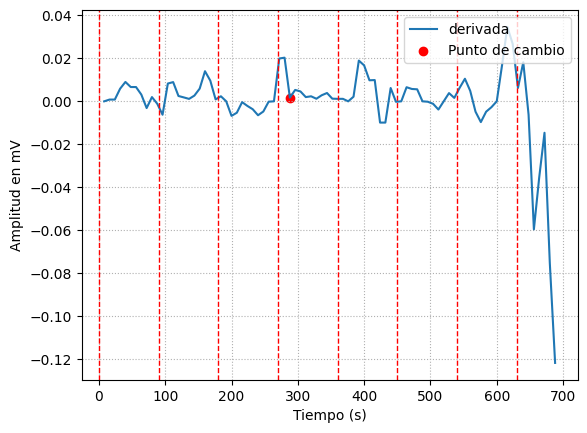

In [ ]:
derivada = np.gradient(smoothed_emg_median)
plt.figure()
plt.plot(xarray, derivada, label="derivada")
plt.scatter(t[change_point]*8000, derivada[change_point], color='red', label='Punto de cambio')

plt.grid(linestyle=":")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud en mV")
plt.legend(loc="upper right")
for i in range(8):
  plt.axvline(x=90*i, color='red', linestyle='--', linewidth=1)
plt.show()

280.0


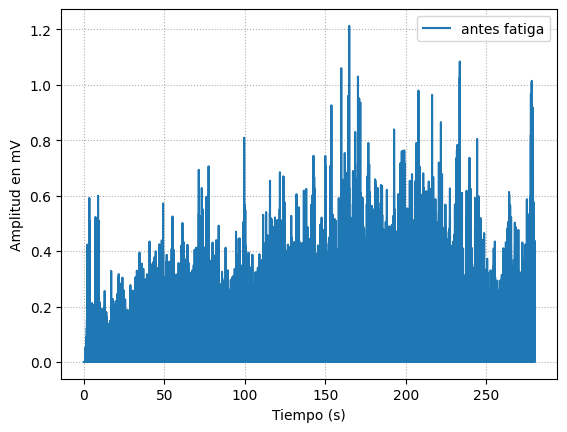

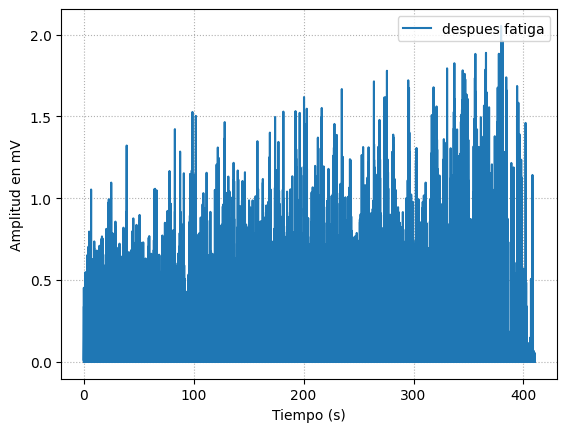

In [ ]:

# Separación de arrays
corte2=change_point*8000
print(corte2/1000)

antes_fatiga= rectified_signal[:corte2]
despues_fatiga = rectified_signal[corte2:]
t1 = np.arange(1, len(antes_fatiga)+1)/Fs
t2 = np.arange(1, len(despues_fatiga)+1)/Fs

plt.figure()
plt.plot(t1,antes_fatiga, label="antes fatiga")
plt.grid(linestyle=":")
plt.legend(loc="upper right")

plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud en mV")

plt.show()

plt.figure()
plt.plot(t2,despues_fatiga, label="despues fatiga")
plt.legend(loc="upper right")

plt.grid(linestyle=":")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud en mV")
plt.show()


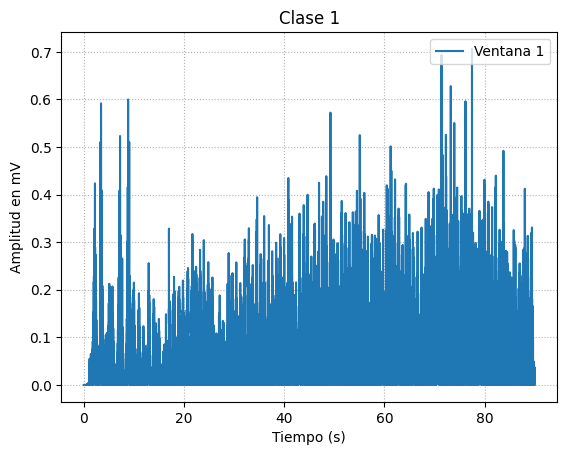

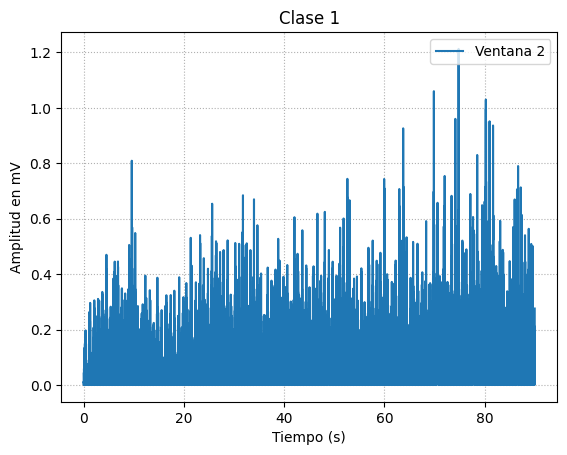

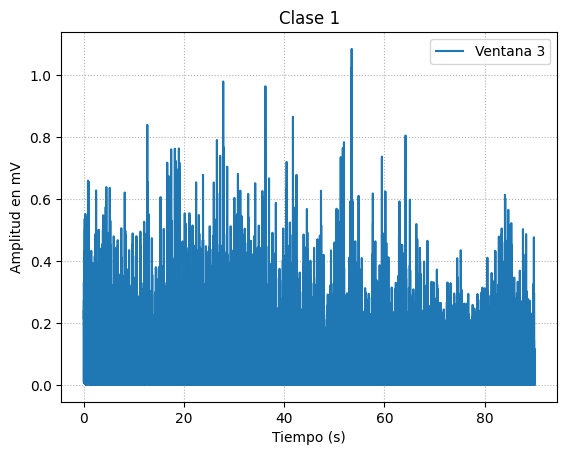

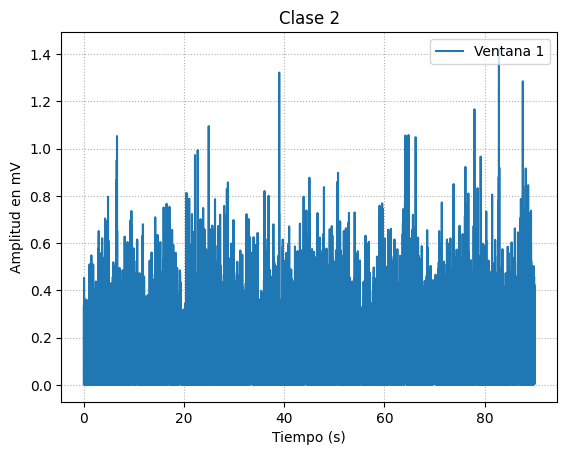

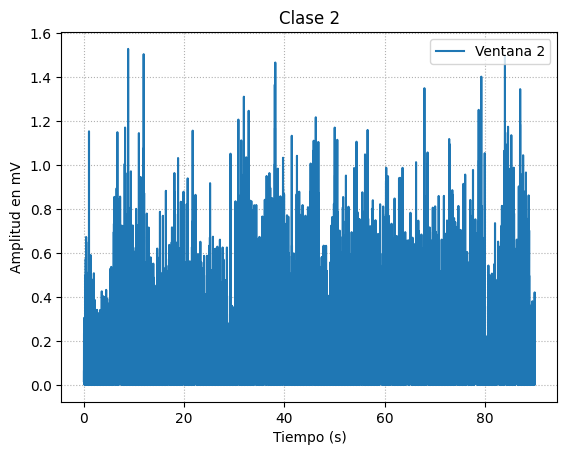

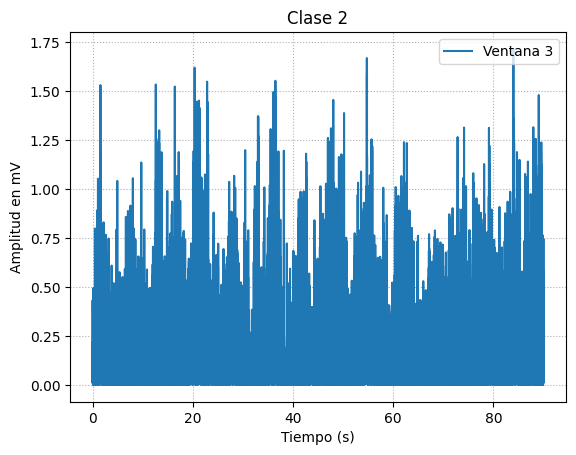

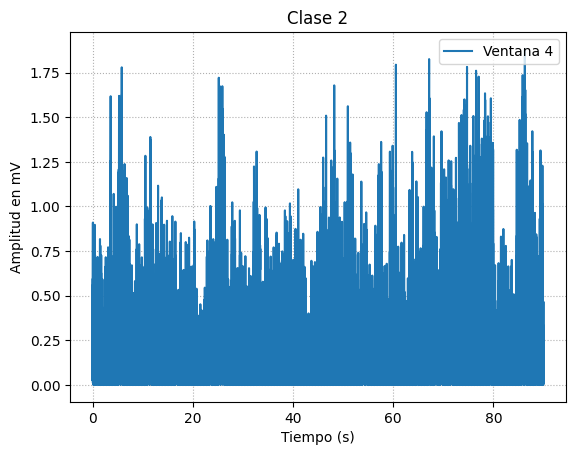

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def divide_en_ventanas(signal, ventana_size, step_size, Fs):
    ventanas = []
    for i in range(0, len(signal) - ventana_size + 1, step_size):
        ventana = signal[i:i + ventana_size]
        ventanas.append(ventana)
    return ventanas

def graficar_ventanas(arrays, Fs, clase):
    for i, ventana in enumerate(arrays):
        tiempo = np.arange(1, len(ventana) + 1) / Fs
        plt.figure()
        plt.plot(tiempo, ventana, label=f'Ventana {i + 1}')
        plt.xlabel('Tiempo (s)')
        plt.ylabel('Amplitud en mV')
        plt.title(f'Clase {clase}')
        plt.legend(loc='upper right')
        plt.grid(linestyle=':')
        plt.show()

Fs = 1000
ventana_size = int(90 * Fs)
step_size = int(90 * Fs)

ventanas_antes_fatiga = divide_en_ventanas(antes_fatiga, ventana_size, step_size, Fs)
ventanas_despues_fatiga = divide_en_ventanas(despues_fatiga, ventana_size, step_size, Fs)

arrays_antes_fatiga = [np.array(ventana) for ventana in ventanas_antes_fatiga]
arrays_despues_fatiga = [np.array(ventana) for ventana in ventanas_despues_fatiga]

# Graficas Antes de la fatiga Ventanas 1 -6
graficar_ventanas(arrays_antes_fatiga, Fs, clase='1')

# Graficar Después de la fatiga Ventana 1
graficar_ventanas(arrays_despues_fatiga, Fs, clase='2')



In [ ]:
import numpy as np

# Función para calcular los valores de características para cada ventana
def calcular_caracteristicas(arrays):
    for i, ventana in enumerate(arrays):
        rms = np.sqrt(np.mean(ventana ** 2))
        mean = np.mean(ventana)
        std = np.std(ventana)
        amplitude = np.max(ventana) - np.min(ventana)
        max_sample_value = np.max(ventana)
        min_sample_value = np.min(ventana)

        print(f"\nCaracterísticas de la Ventana {i + 1}:")
        print(f"Root Mean Square (rms): {rms}")
        print(f"Mean EMG (media): {mean}")
        print(f"Standard Deviation  EMG (desviacion_estándar): {std}")
        print(f"Amplitude (amplitud): {amplitude}")
        print(f"Maximo valor EMG: {max_sample_value}")
        print(f"Minimo valor EMG: {min_sample_value}")

# Calcular características para ventanas antes de la fatiga
calcular_caracteristicas(arrays_antes_fatiga)

# Calcular características para ventanas después de la fatiga
calcular_caracteristicas(arrays_despues_fatiga)



Características de la Ventana 1:
Root Mean Square (rms): 0.07130310515072903
Mean EMG (media): 0.044307636038580386
Standard Deviation  EMG (desviacion_estándar): 0.05586560831861238
Amplitude (amplitud): 0.706044798359868
Maximo valor EMG: 0.706044798359868
Minimo valor EMG: 5.3330080187625695e-45

Características de la Ventana 2:
Root Mean Square (rms): 0.10281687763461919
Mean EMG (media): 0.06351661640478058
Standard Deviation  EMG (desviacion_estándar): 0.08085140547337574
Amplitude (amplitud): 1.2127412704360674
Maximo valor EMG: 1.2127421974087222
Minimo valor EMG: 9.269726547997855e-07

Características de la Ventana 3:
Root Mean Square (rms): 0.11426048987311677
Mean EMG (media): 0.07402625904821264
Standard Deviation  EMG (desviacion_estándar): 0.08703776489186482
Amplitude (amplitud): 1.0842869229105103
Maximo valor EMG: 1.0842876124356906
Minimo valor EMG: 6.895251802559274e-07

Características de la Ventana 1:
Root Mean Square (rms): 0.1604765974557119
Mean EMG (media): 0.

In [ ]:

rms = np.sqrt(np.sum(filtered_signal2*filtered_signal2)/len(filtered_signal2))
mean=np.mean(filtered_signal2)
std=np.std(filtered_signal2)
amplitude=np.max(filtered_signal2)-np.min(filtered_signal2)



print(f"Root Mean Square (rms): {rms}")
print(f"Mean EMG (media): {mean}")
print(f"Standard Deviation  EMG(desviacion_estándar): {std}")
print(f"Amplitude (amplitud): {amplitude}")

max_sample_value = max(filtered_signal2)
print(f"Maximo valor EMG: {max_sample_value}")


min_sample_value = min(filtered_signal2)
print(f"Minimo valor EMG: {min_sample_value}")

area=cumtrapz(filtered_signal2)
f,P=welch(filtered_signal2,fs=1000,window='hann',noverlap=0,nfft=int(256.))
area_freq=cumtrapz(P,f,initial=0)
total_power=area_freq[-1]
median_freq=f[np.where(area_freq>total_power/2)[0][0]]
f_max=f[np.argmax(P)]
print("Área bajo la curva:", area[-1])
print("Potencia Total:", total_power)
print("Frecuencia Mediana:",median_freq)
print("Frecuencia con Máxima Potencia:", f_max)


Root Mean Square (rms): 0.18572660087256654
Mean EMG (media): 2.595288103340129e-08
Standard Deviation  EMG(desviacion_estándar): 0.18572660087256476
Amplitude (amplitud): 4.011493246337613
Maximo valor EMG: 2.0532851439277007
Minimo valor EMG: -1.9582081024099127
Área bajo la curva: 0.012118033159281661
Potencia Total: 0.034514286475383814
Frecuencia Mediana: 58.59375
Frecuencia con Máxima Potencia: 50.78125


In [ ]:
"""plt.figure(figsize=(8, 4))
plt.specgram(filtered_signal2, Fs=1000, cmap='viridis')

plt.title('Espectrograma de una señal')
plt.xlabel('Tiempo (s)')
plt.ylabel('Frecuencia (Hz)')

plt.colorbar(label='Intensidad (dB)')
plt.show()


wavelet = 'morl'  # Tipo de wavelet (en este caso, Morlet)
scales = np.arange(1, 128)  # Escalas de análisis
sampling_period = 1 / 1000  # Período de muestreo de la señal

# Realizar la Transformada Wavelet Continua
coeffs, freqs = pywt.cwt(filtered_signal2, scales, wavelet, sampling_period)

# Graficar la CWT
plt.figure(figsize=(10, 6))
plt.imshow(np.abs(coeffs), extent=[0, len(filtered_signal2), freqs.min(), freqs.max()], aspect='auto', cmap='viridis')
plt.colorbar(label='Amplitud')
plt.title('Transformada Wavelet Continua')
plt.xlabel('Tiempo (muestras)')
plt.ylabel('Frecuencia (Hz)')
plt.show()"""

"plt.figure(figsize=(8, 4))\nplt.specgram(filtered_signal2, Fs=1000, cmap='viridis')\n\nplt.title('Espectrograma de una señal')\nplt.xlabel('Tiempo (s)')\nplt.ylabel('Frecuencia (Hz)')\n\nplt.colorbar(label='Intensidad (dB)')\nplt.show()\n\n\nwavelet = 'morl'  # Tipo de wavelet (en este caso, Morlet)\nscales = np.arange(1, 128)  # Escalas de análisis\nsampling_period = 1 / 1000  # Período de muestreo de la señal\n\n# Realizar la Transformada Wavelet Continua\ncoeffs, freqs = pywt.cwt(filtered_signal2, scales, wavelet, sampling_period)\n\n# Graficar la CWT\nplt.figure(figsize=(10, 6))\nplt.imshow(np.abs(coeffs), extent=[0, len(filtered_signal2), freqs.min(), freqs.max()], aspect='auto', cmap='viridis')\nplt.colorbar(label='Amplitud')\nplt.title('Transformada Wavelet Continua')\nplt.xlabel('Tiempo (muestras)')\nplt.ylabel('Frecuencia (Hz)')\nplt.show()"

In [ ]:
import csv

def convert_txt_to_csv(input_file, output_file, delimiter='\t'):
    with open(input_file, 'r') as txt_file, open(output_file, 'w', newline='') as csv_file:
        reader = csv.reader(txt_file, delimiter=delimiter)
        writer = csv.writer(csv_file)

        for row in reader:
            if len(row) >= 6:
                writer.writerow([row[5]])

input_txt_file = 'gf.txt'
output_csv_file = 'gf.csv'

convert_txt_to_csv(input_txt_file, output_csv_file)


In [ ]:
"""
# Importamos librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
# Extraemos datos
data="gf.csv"
#visualizamos el dataset
df= pd.read_csv(data)
df.head()

import csv

def classify_and_save_to_csv(input_file, output_file, corte):
    with open(input_file, 'r') as infile:
        reader = csv.reader(infile)
        header = next(reader)
        data = [(float(row[0]),) for row in reader]

    class_1 = [(value, 'Class 1', '') for value, in data[:corte]]
    class_2 = [(value, '', 'Class 2') for value, in data[corte:]]

    with open(output_file, 'w', newline='') as outfile:
        writer = csv.writer(outfile)
        writer.writerow(['Value', 'Class 1', 'Class 2'])
        for value, class1, class2 in class_1:
            writer.writerow([value, class1, class2])
        for value, class1, class2 in class_2:
            writer.writerow([value, class1, class2])

# Example usage
input_csv_file = 'gf.csv'
output_csv_file = 'classified_data.csv'

classify_and_save_to_csv(input_csv_file, output_csv_file, corte2)
"""


'\n# Importamos librerias\nimport numpy as np\nimport pandas as pd\nimport matplotlib.pyplot as plt\nimport seaborn as sns\nimport statsmodels.api as sm\nfrom sklearn.preprocessing import PolynomialFeatures\n# Extraemos datos\ndata="gf.csv"\n#visualizamos el dataset\ndf= pd.read_csv(data)\ndf.head()\n\nimport csv\n\ndef classify_and_save_to_csv(input_file, output_file, corte):\n    with open(input_file, \'r\') as infile:\n        reader = csv.reader(infile)\n        header = next(reader)\n        data = [(float(row[0]),) for row in reader]\n\n    class_1 = [(value, \'Class 1\', \'\') for value, in data[:corte]]\n    class_2 = [(value, \'\', \'Class 2\') for value, in data[corte:]]\n\n    with open(output_file, \'w\', newline=\'\') as outfile:\n        writer = csv.writer(outfile)\n        writer.writerow([\'Value\', \'Class 1\', \'Class 2\'])\n        for value, class1, class2 in class_1:\n            writer.writerow([value, class1, class2])\n        for value, class1, class2 in class_

In [ ]:
"""import csv
import numpy as np

def calcular_caracteristicas(arrays, clase):
    caracteristicas = []
    for i, ventana in enumerate(arrays):
        rms = np.sqrt(np.mean(ventana ** 2))
        mean = np.mean(ventana)
        std = np.std(ventana)
        amplitude = np.max(ventana) - np.min(ventana)
        max_sample_value = np.max(ventana)
        min_sample_value = np.min(ventana)

        caracteristicas.append([clase, i + 1, rms, mean, std, amplitude, max_sample_value, min_sample_value])

    return caracteristicas

caracteristicas_antes_fatiga = calcular_caracteristicas(arrays_antes_fatiga, clase='Clase 1')
caracteristicas_despues_fatiga = calcular_caracteristicas(arrays_despues_fatiga, clase='Clase 2')
todas_caracteristicas = caracteristicas_antes_fatiga + caracteristicas_despues_fatiga

archivo_csv = 'caracteristicas_ventanas.csv'
with open(archivo_csv, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Clase', 'Etiqueta', 'RMS', 'Media', 'Desviacion_Estandar', 'Amplitud', 'Maximo', 'Minimo'])
    writer.writerows(todas_caracteristicas)"""



"import csv\nimport numpy as np\n\ndef calcular_caracteristicas(arrays, clase):\n    caracteristicas = []\n    for i, ventana in enumerate(arrays):\n        rms = np.sqrt(np.mean(ventana ** 2))\n        mean = np.mean(ventana)\n        std = np.std(ventana)\n        amplitude = np.max(ventana) - np.min(ventana)\n        max_sample_value = np.max(ventana)\n        min_sample_value = np.min(ventana)\n\n        caracteristicas.append([clase, i + 1, rms, mean, std, amplitude, max_sample_value, min_sample_value])\n\n    return caracteristicas\n\ncaracteristicas_antes_fatiga = calcular_caracteristicas(arrays_antes_fatiga, clase='Clase 1')\ncaracteristicas_despues_fatiga = calcular_caracteristicas(arrays_despues_fatiga, clase='Clase 2')\ntodas_caracteristicas = caracteristicas_antes_fatiga + caracteristicas_despues_fatiga\n\narchivo_csv = 'caracteristicas_ventanas.csv'\nwith open(archivo_csv, 'w', newline='') as csvfile:\n    writer = csv.writer(csvfile)\n    writer.writerow(['Clase', 'Etique

In [ ]:
!pip install scikit-learn pandas
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score